## 統整
* 52712: raw dataset
    * 19916: 被 rule-based + manually check 篩掉的 + flatten folder 時會把重複的 ID_filename 丟掉(37 張)
    * 32796 + 1(少送一張到 dlib，不知道發生了什麼. `id_00000001_02_1_front.jpg`)
        * 27753: 使用 dlib 偵測 facial landmarks (為了和 FFHQ 一樣的 face alignment)
            * train: 22202
            * val: 5272
            * test: 277
        * 149 : `neg` (x1, y1) 在圖片外(臉只有部份在圖片中)
        * 38 : `big` Dlib 框錯 or 框到衣服上的人臉圖案。導致 box 的 w,h > 200
        * 3621: `nobox` Dlib 沒偵測到臉的
        * 128 : `wrong_pos` Dlib 偵測到的臉的位置不正常。x1 不在中間 1/3, y1 > 1/3 --> 手動刪除不合格的 (有一個 model 手上有人臉刺青 ... 大約50張)

# 1. Try In-Shop-Clothes-Retrieval

1. Extract images from zip to temporary dir
2. filter by with_face_path.txt
3. flatten folder structure if needed.
4. output directory will be DeepFashion_images_\<timestamp\>.

In [1]:
import os
import shutil
import datetime
import tempfile
from zipfile import ZipFile
from pathlib import Path

In [2]:
ZIP_PATH = Path('./img_highres.zip')
FILTER_FILE = Path('with_face_path.txt')
OUTPUT_DIR = Path('~/data/deepfashion_h_filtered_test').expanduser()
# Keep folder structure or nothttps://www.facebook.com/110907234421853/photos/p.217934667052442/217934667052442/
FLATTEN = False

In [3]:
assert FILTER_FILE.exists(), "file for filter images not found"
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True)
    
PASSWORD = {
    'In-shop-Clothers-Retrieval': 'mmlab_DeepFashion_inshop',
}

EXTRACTED_DIR = Path(tempfile.TemporaryDirectory().name)

In [5]:
members = [ZIP_PATH.stem + '/' + p for p in Path('with_face_path.txt').read_text().split('\n')[:20]]
# with open('with_face_path.txt', 'r') as f:
#     members = set([ZIP_PATH.stem + '/' + p.strip('\n') for p in f.readlines()])
    
with ZipFile(ZIP_PATH, 'r') as zipObj:
    zipObj.extractall(EXTRACTED_DIR, members, PASSWORD['In-shop-Clothers-Retrieval'].encode('utf-8'))

    
now_str = 'DeepFashion_images_' + datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
final_output_dir = OUTPUT_DIR / now_str
if not final_output_dir.exists():
    final_output_dir.mkdir()

if FLATTEN:
    for p in EXTRACTED_DIR.glob('**/*.jpg'):
        filename = '_'.join(p.parts[-2:])
        shutil.move(p, final_output_dir / filename)
else:
    (EXTRACTED_DIR / ZIP_PATH.stem).rename(final_output_dir)

* There are some(25) duplicate images in this datasets(but in different category). 
* Image resolution information in these images:
   * [((750, 1101), 32718), ((750, 915), 101), ((750, 1102), 1), ((2574, 3861), 1)]

## 2.重複的 ID + filename pair

In [7]:
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
from IPython.display import display

import matplotlib as mpl
mpl.rcParams['text.color'] = 'w'

In [3]:
ps = list(Path('~/data/deepfashion/img_highres').expanduser().glob('**/*.jpg'))
m = dict()
len(ps)

52712

In [8]:
p

PosixPath('/home/yct/data/deepfashion/img_highres/MEN/Suiting/id_00006912/08_4_full.jpg')

In [6]:
%%time
for p in ps:
    key = '_'.join(p.parts[-2:])
    m.setdefault(key, []).append(p)

CPU times: user 103 ms, sys: 7.65 ms, total: 110 ms
Wall time: 109 ms


total duplicate pairs: 37


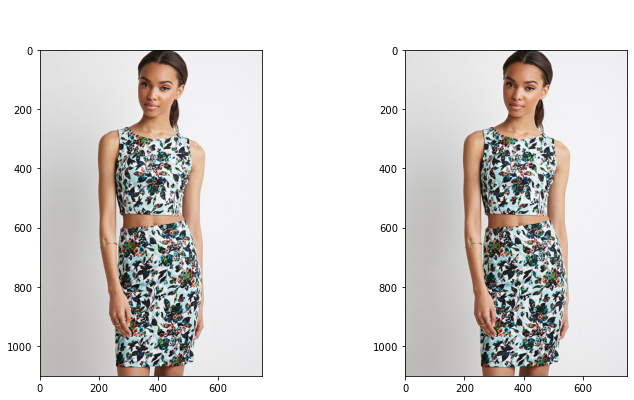

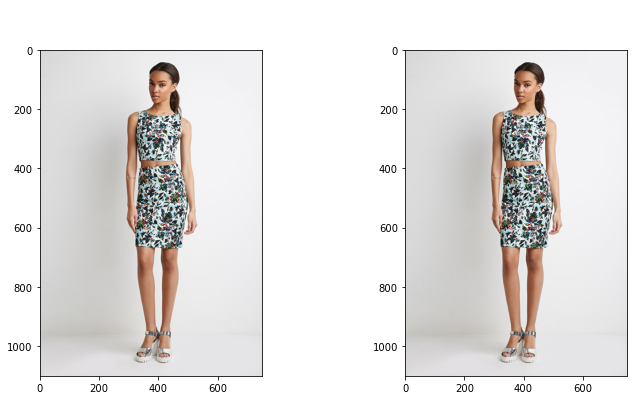

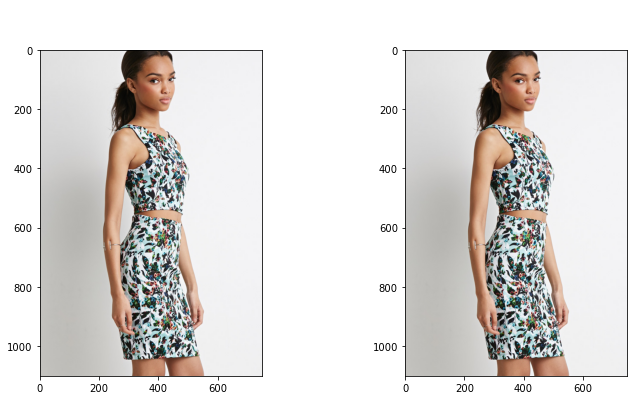

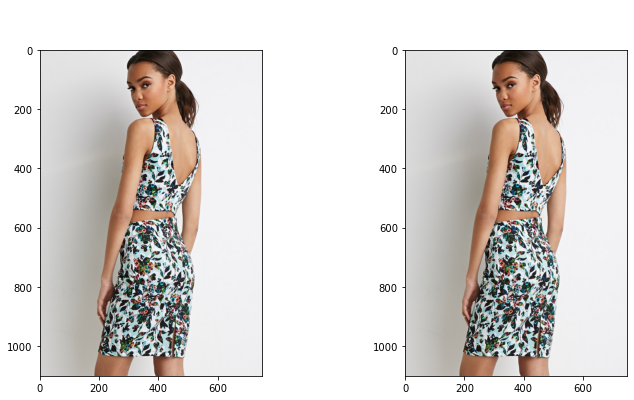

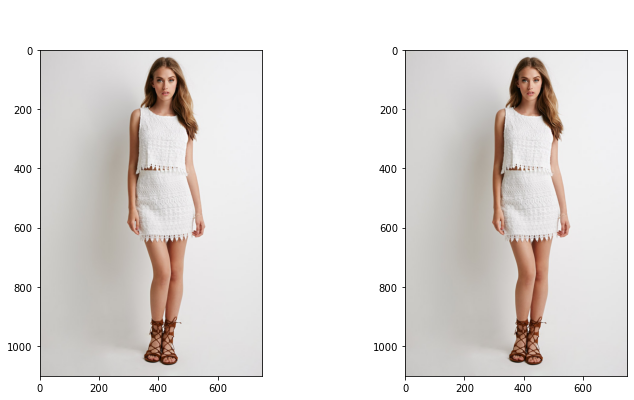

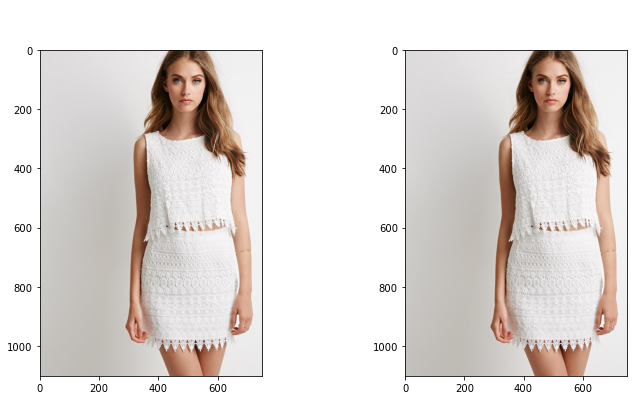

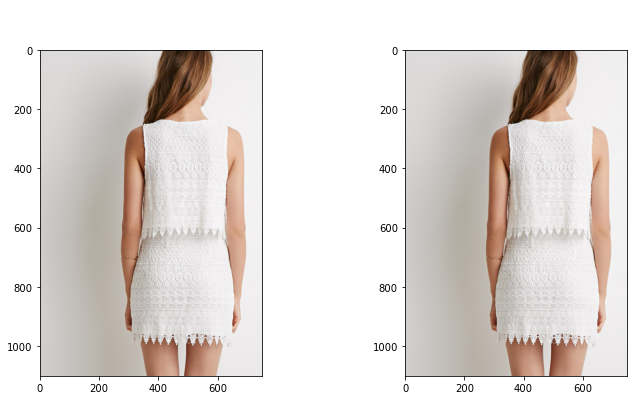

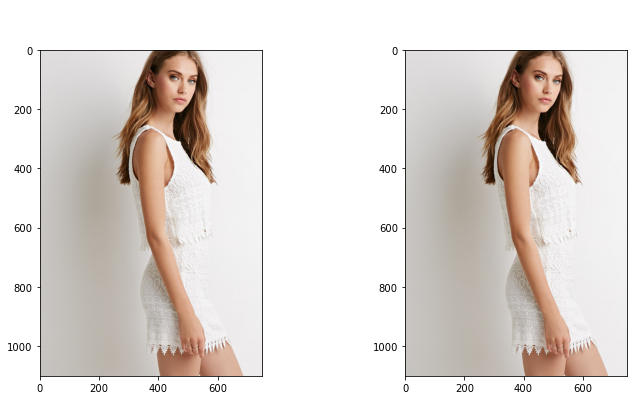

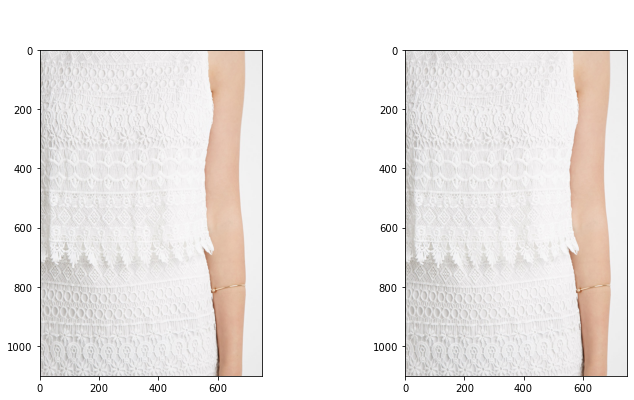

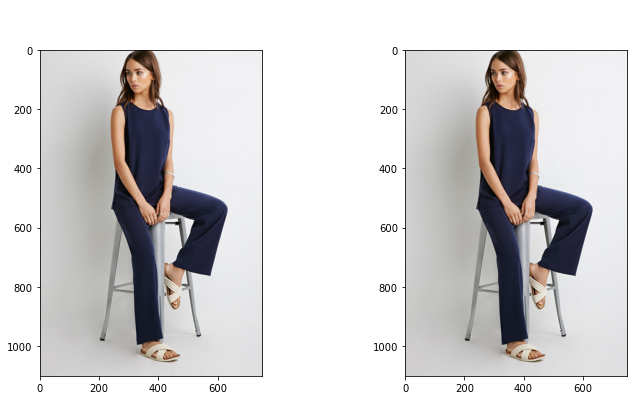

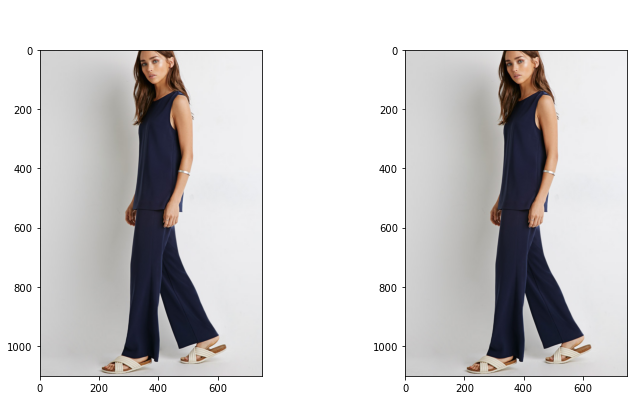

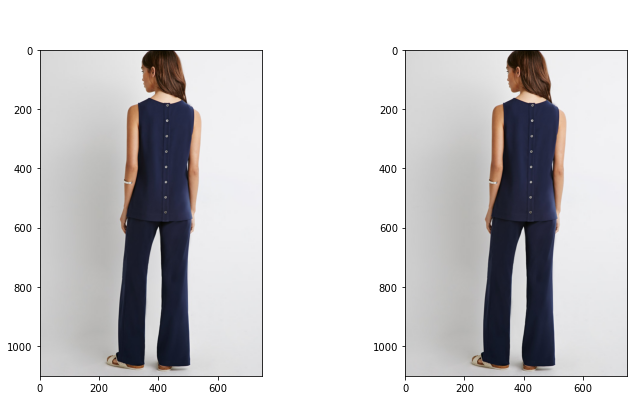

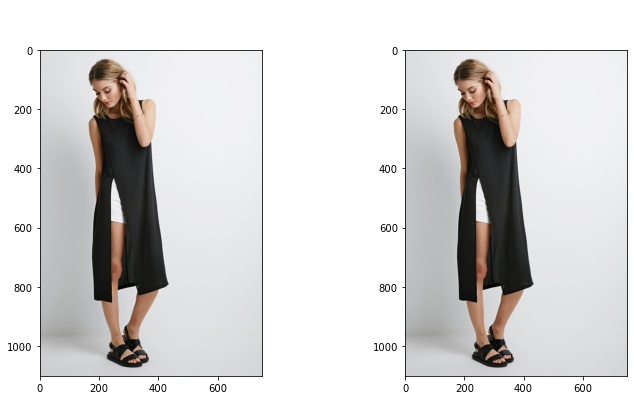

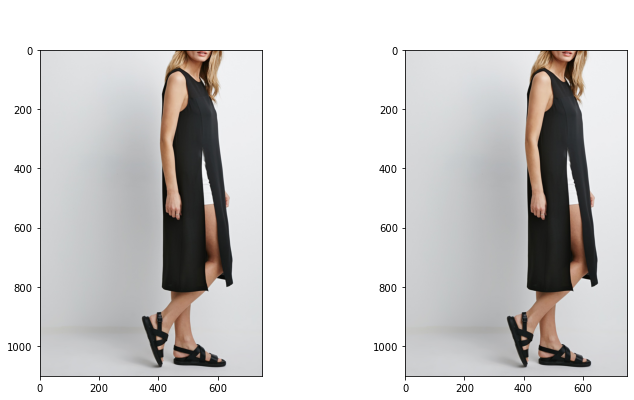

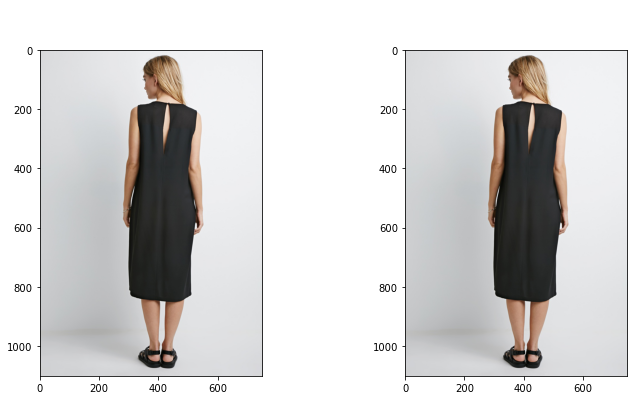

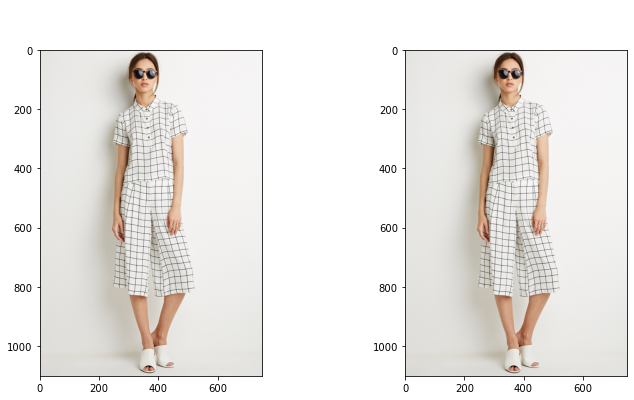

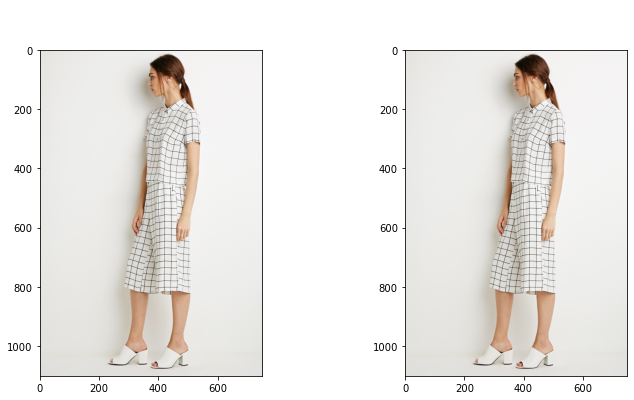

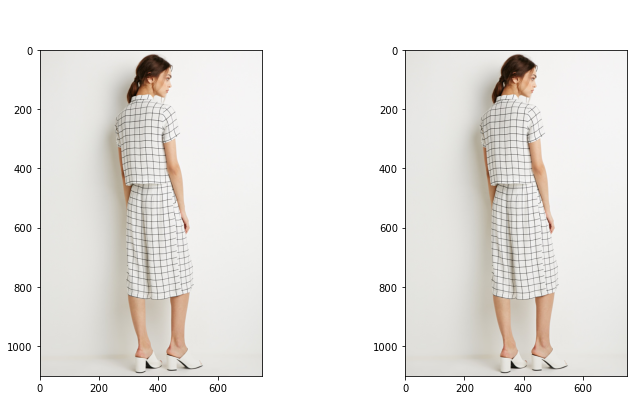

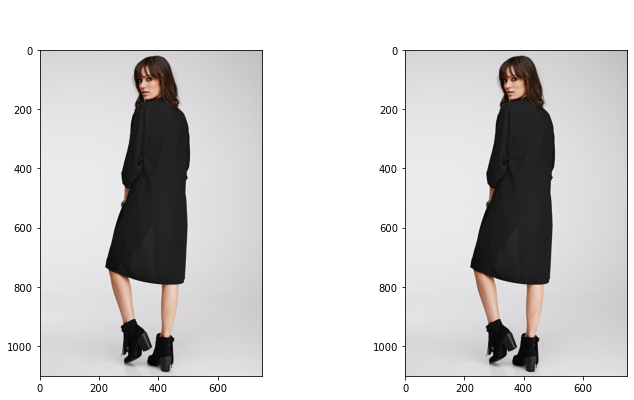

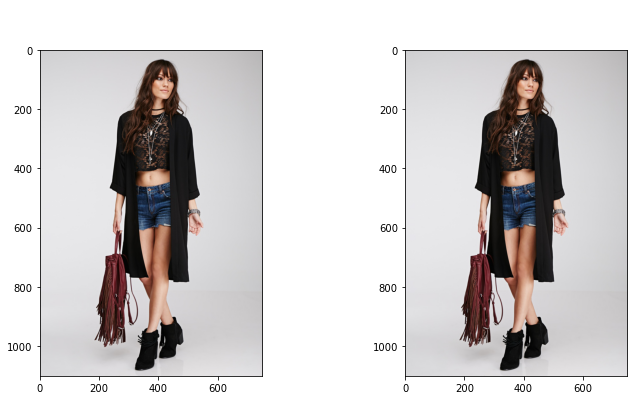

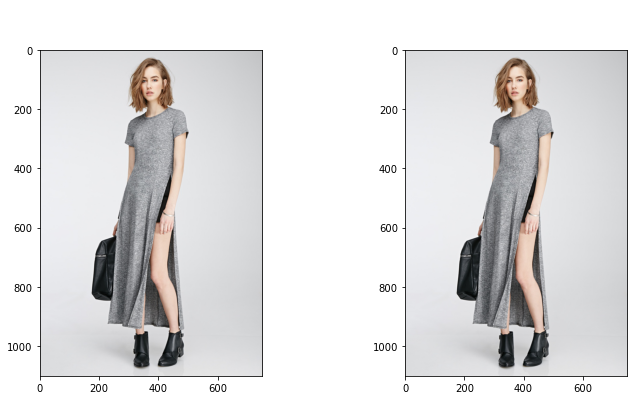

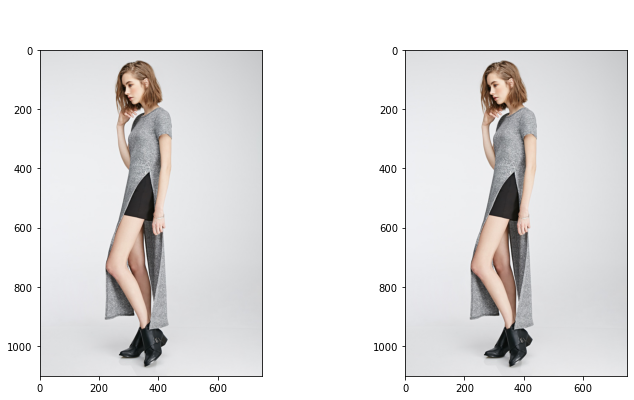

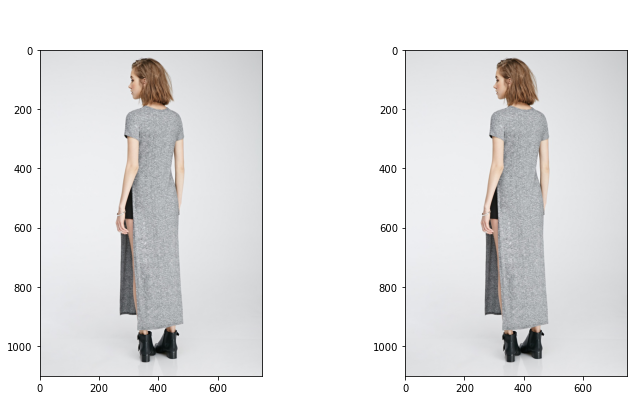

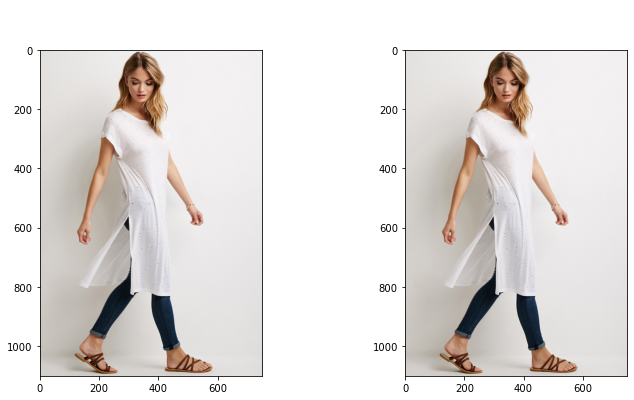

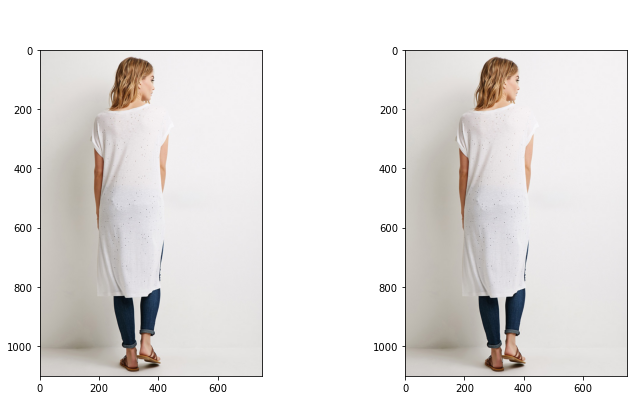

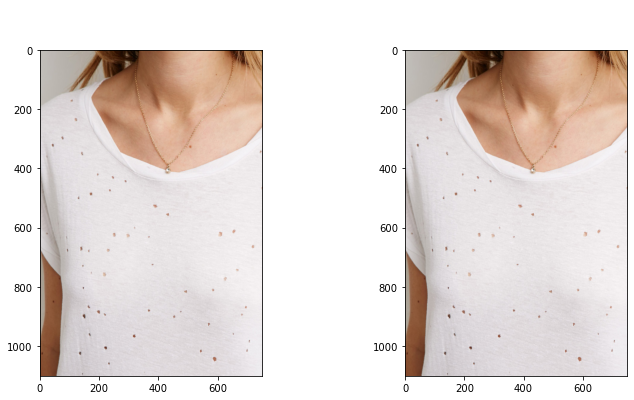

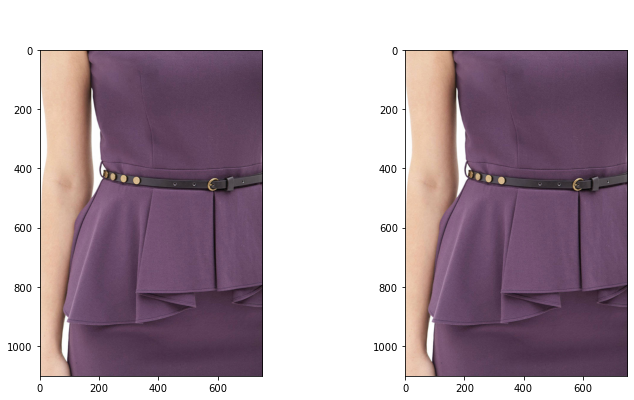

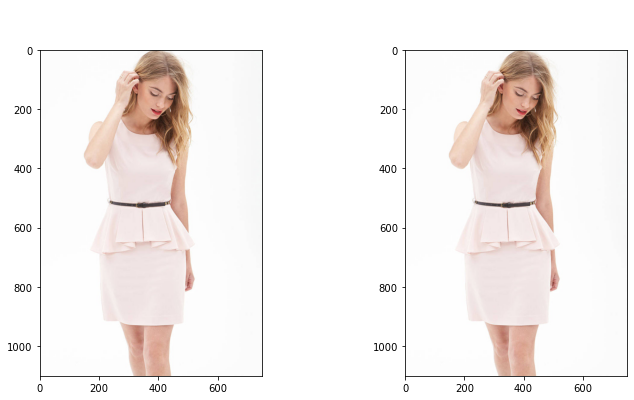

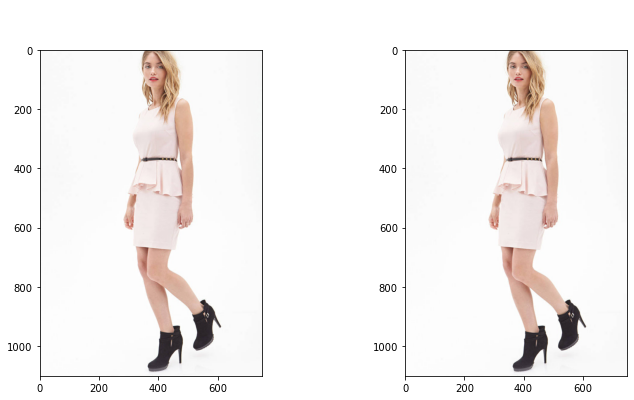

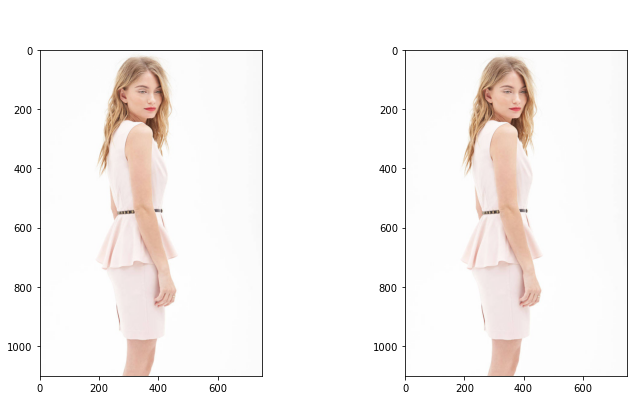

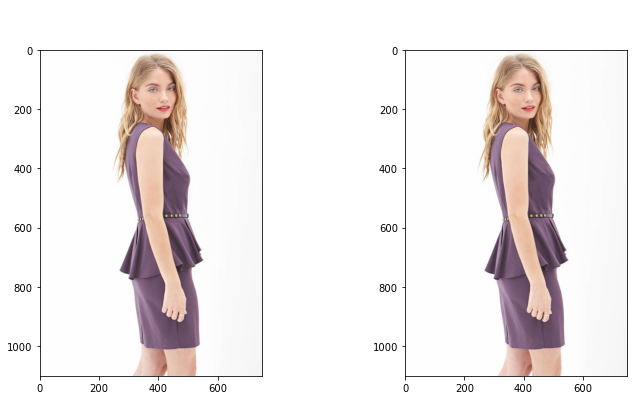

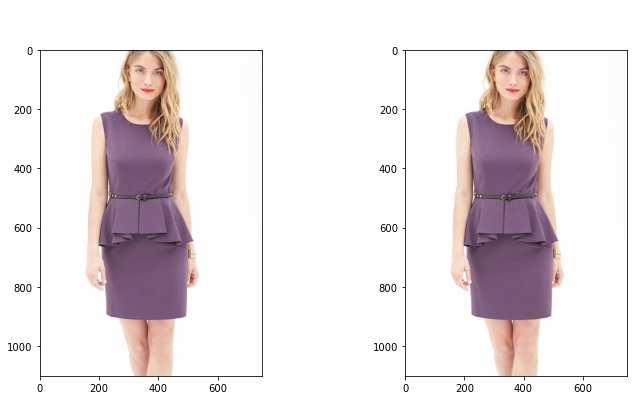

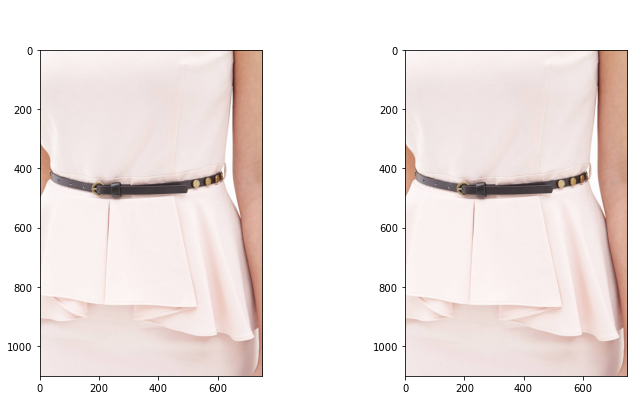

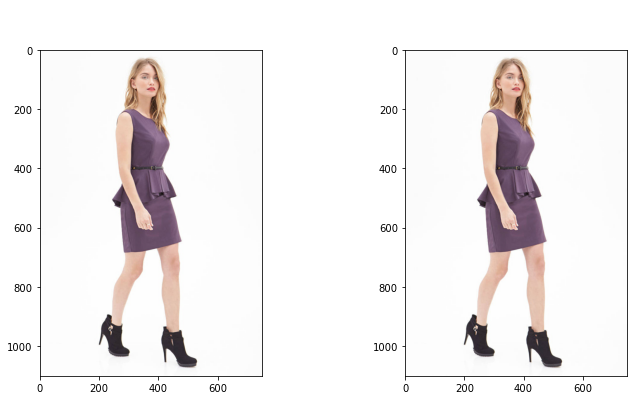

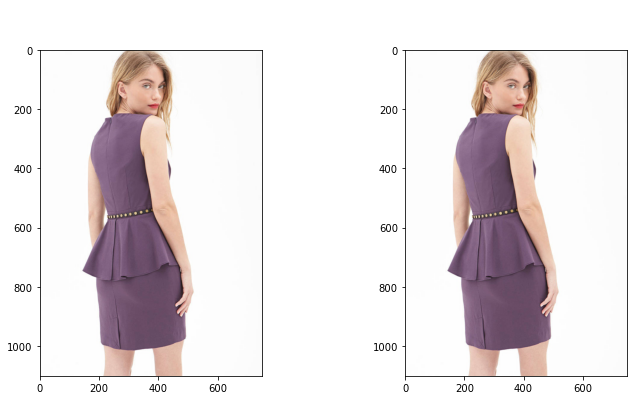

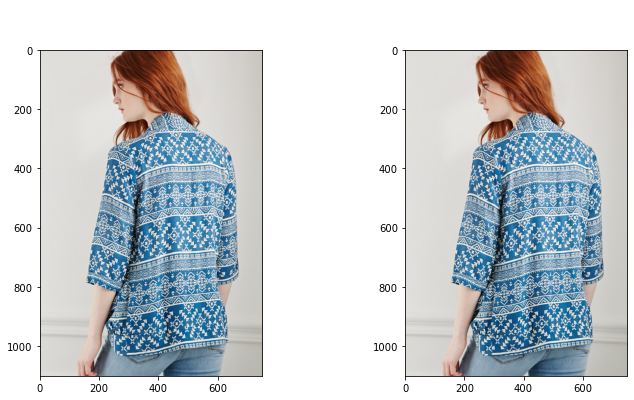

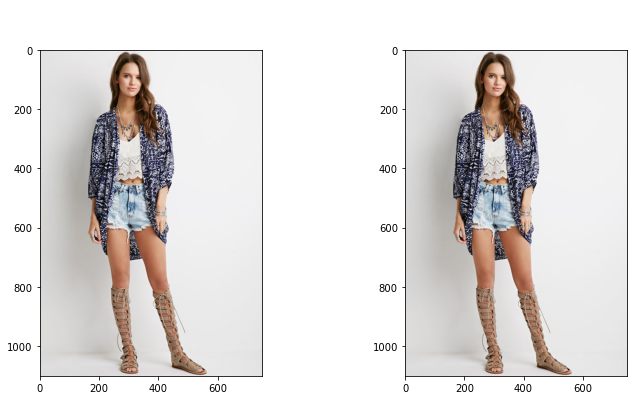

In [19]:
total = sum([1 for vs in m.values() if len(vs) > 1])
print(f"total duplicate pairs: {total}")
for k, vs in m.items():
    if len(vs) > 1:
        fig, ax = plt.subplots(1, len(vs), figsize=(6*len(vs), 6))
        for i, v in enumerate(vs):
            ax[i].set_title(' '.join(v.parts[-4:-2]))
            ax[i].imshow(io.imread(v))
        fig.suptitle(k)
        display(fig)
        plt.close(fig=fig)
            

## 3.Rule Based filtering

In [ ]:
import random
import shutil
from pathlib import Path

import cv2
from PIL import Image
from IPython.display import display
from tqdm import tqdm
from mtcnn import MTCNN

In [27]:
DATASET = 'deepfashion'
CATEGORY = 'In-shop-Clothes-Retrieval'
RES = 'img'
DATA_ROOT = Path(f'../{DATASET}/{CATEGORY}/Img/{RES}').expanduser()
IMG_PATHS = list(DATA_ROOT.glob('**/*.jpg'))

OUTPUT_ROOT = Path('~/data/deepfashion_preprocessed').expanduser()
if not OUTPUT_ROOT.exists():
    (OUTPUT_ROOT / 'tbd').mkdir(parents=True)
    (OUTPUT_ROOT / 'ok').mkdir(parents=True)

In [28]:
detector = MTCNN()

In [29]:
# full & additional & front -> mtcnn -> manually check
type1 = ["Denim", "Pants", "Shorts", "Leggings", "Skirts"]

# side, front, full -> ok, additional-> mtcnn -> manually check
type2 = ["Jackets_Vests", "Shirts_Polos", "Sweaters", "Sweatshirts_Hoodies", "Tees_Tanks", "Blouses_Shirts", "Cardigans",
         "Dresses", "Graphic_Tees", "Jackets_Coats", "Rompers_Jumpsuits"]
# skip 
type3 = ["Suiting"]

In [30]:
fail_paths = []
for p in tqdm(IMG_PATHS):
    cloth_type = p.parts[-3]
    
    if cloth_type in type1:
        if 'full' in p.name or 'additional' in p.name or 'front' in p.name:
            shutil.copy(p, OUTPUT_ROOT / 'tbd' / '_'.join(p.parts[-2:]))
    elif cloth_type in type2:
        if 'side' in p.name or 'front' in p.name or 'full' in p.name:
            shutil.copy(p, OUTPUT_ROOT / 'ok' / '_'.join(p.parts[-2:]))
        elif 'additional' in p.name:
            img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(img)
            if len(results) == 1:
                shutil.copy(p, OUTPUT_ROOT / 'ok' / '_'.join(p.parts[-2:]))
    elif cloth_type in type3:
        continue
    else:
        raise RuntimeError(f'not defined type: {cloth_type}')  

100%|██████████| 52712/52712 [03:17<00:00, 266.23it/s]


## 4.Preprocessing - Padding & Resize
* Only preprocess (750, 1101). discard others (103 images)
* padding & resize to square
* not handle for nested structure above. It will only save as Flatten type

In [3]:
from pathlib import Path
from PIL import Image, ImageOps
from tqdm import tqdm

In [ ]:
# IMG_DIR = Path('~/data/deepfashion_h/DeepFashion_images_2020-07-30_13-48-12').expanduser()
# IMG_DIR = final_output_dir

In [ ]:
OUT_DIR = IMG_DIR.parent / '1024x1024'
img_paths = list(IMG_DIR.glob('**/*.jpg'))
len(img_paths)

In [ ]:
for p in tqdm(img_paths):
    img_out = ImageOps.expand(Image.open(p), (137, 0, 137, 0), 'white').resize((1024,1024), Image.ANTIALIAS).save(OUT_DIR / p.name)

### 2021/09/30 count aspect ratio of original high_res image

In [1]:
from pathlib import Path
from PIL import Image

aspect_ratios = set()
for p in Path('flatten_raw_images1024').glob('*.jpg'):
    img = Image.open(p)
    aspect_ratios.add(img.size)
    
aspect_ratios

{(750, 915),
 (750, 1100),
 (750, 1101),
 (750, 1102),
 (804, 1139),
 (2114, 3171),
 (2136, 3205),
 (2574, 3861)}